In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy import stats
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
path = "./../data/prep_1/train"
indices = np.arange(0, 205942, dtype=np.int64)

pkl_list = glob(os.path.join(path, '*'))
pkl_list.sort()

In [3]:
inp_data_pitt = []
inp_data_miami = []
out_data_pitt = []
out_data_miami = []

In [4]:
for i in range(indices.shape[0]):
    pkl_path = pkl_list[indices[i]]
    with open(pkl_path, 'rb') as f:
        scene = pickle.load(f)
    
    lane = scene['lane']
    inp = scene['inp_scene'][:, :2]
    out = scene['out_scene'][:, :2]

    # inp_data.append(inp)

    max_lane = np.max(lane, axis=0)
    min_lane = np.min(lane, axis=0)


    min_vec = scene['normalize_min']
    max_vec = scene['normalize_max']

    inp = (scene['inp_scene'] * (max_vec - min_vec)) + min_vec
    out = (scene['out_scene'] * (max_vec - min_vec)) + min_vec
    
    if scene['city'] == 'PIT':
        inp_data_pitt.append(inp)
        out_data_pitt.append(out)
    else:
        inp_data_miami.append(inp)
        out_data_miami.append(out)



In [5]:
inp_data_miami = np.array(inp_data_miami)
inp_data_pitt = np.array(inp_data_pitt)
out_data_miami = np.array(out_data_miami)
out_data_pitt = np.array(out_data_pitt)

In [6]:
max_inp_miami = np.max(inp_data_miami)
min_inp_miami = np.min(inp_data_miami)
max_inp_pitt = np.max(inp_data_pitt)
min_inp_pitt = np.min(inp_data_pitt)

max_out_miami = np.max(out_data_miami)
min_out_miami = np.min(out_data_miami)
max_out_pitt = np.max(out_data_pitt)
min_out_pitt = np.min(out_data_pitt)

In [7]:
resolution = 1

grid_size_miami = int((max_inp_miami - min_inp_miami) / resolution) + 1
grid_size_pitt = int((max_inp_pitt - min_inp_pitt) / resolution) + 1

grid_miami = np.zeros((grid_size_miami, grid_size_miami))
grid_pitt = np.zeros((grid_size_pitt, grid_size_pitt))

In [8]:
inp_temp_miami = np.reshape(inp_data_miami, (-1, 2))
inp_temp_pitt = np.reshape(inp_data_pitt, (-1, 2))

out_temp_miami = np.reshape(out_data_miami, (-1, 2))
out_temp_pitt = np.reshape(out_data_pitt, (-1, 2))

In [9]:
for i in range(inp_temp_miami.shape[0]):
    x = int((inp_temp_miami[i, 0] - min_inp_miami) / resolution)
    y = int((inp_temp_miami[i, 1] - min_inp_miami) / resolution)
    if grid_miami[x, y] < 20:
        grid_miami[x, y] += 1

for i in range(inp_temp_pitt.shape[0]):
    x = int((inp_temp_pitt[i, 0] - min_inp_pitt) / resolution)
    y = int((inp_temp_pitt[i, 1] - min_inp_pitt) / resolution)
    if grid_pitt[x, y] < 20:
        grid_pitt[x, y] += 1

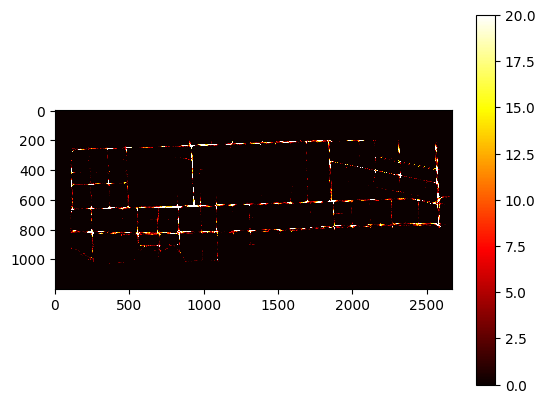

In [10]:
plt.imshow(grid_miami[:1200, 1500:], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.savefig('./miami_inp.png')

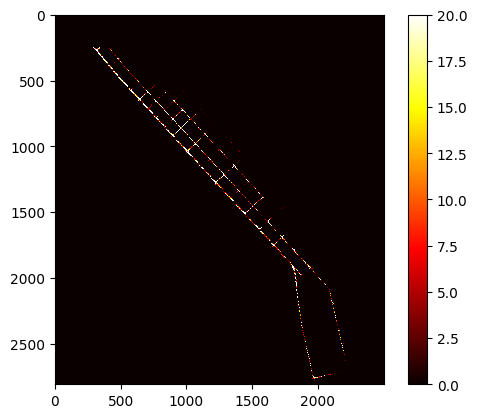

In [11]:
plt.imshow(grid_pitt[2000:, 500:3000], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.savefig('./pitt_inp.png')

In [12]:
resolution_out = 1
grid_out_size_miami = int((max_out_miami - min_out_miami) / resolution_out) + 1
grid_out_size_pitt = int((max_out_pitt - min_out_pitt) / resolution_out) + 1

grid_out_miami = np.zeros((grid_out_size_miami, grid_out_size_miami))
grid_out_pitt = np.zeros((grid_out_size_pitt, grid_out_size_pitt))

In [13]:
for i in range(out_temp_miami.shape[0]):
    x = int((out_temp_miami[i, 0] - min_out_miami) / resolution_out)
    y = int((out_temp_miami[i, 1] - min_out_miami) / resolution_out)
    if grid_out_miami[x, y] < 30:
        grid_out_miami[x, y] += 1

for i in range(out_temp_pitt.shape[0]):
    x = int((out_temp_pitt[i, 0] - min_out_pitt) / resolution_out)
    y = int((out_temp_pitt[i, 1] - min_out_pitt) / resolution_out)
    if grid_out_pitt[x, y] < 30:
        grid_out_pitt[x, y] += 1

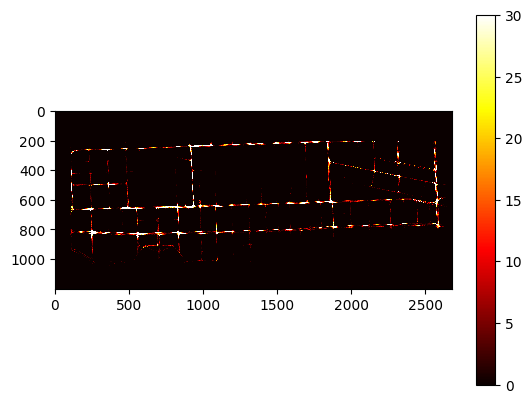

In [14]:
plt.imshow(grid_out_miami[:1200, 1500:], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.savefig('./miami_out.png')

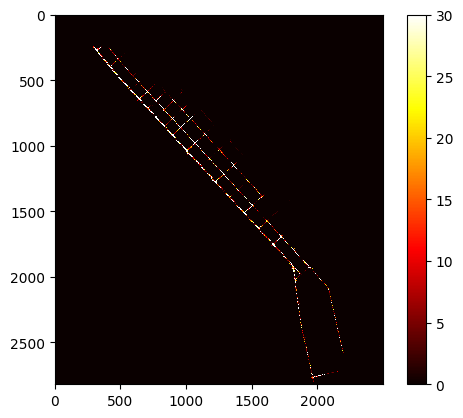

In [15]:
plt.imshow(grid_out_pitt[2000:, 500:3000], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.savefig('./pitt_out.png')

In [16]:
print(inp_data_miami.shape)

(110421, 19, 4)


In [17]:
print(inp_data_pitt.shape)

(95521, 19, 4)


In [18]:
def check_straight_line(points):
    # Extract x and y coordinates from the points
    x = [point[0] for point in points]
    y = [point[1] for point in points]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # If the p-value is below a threshold (e.g., 0.05), the points approximately fit on a straight line
    threshold = 0.05
    if p_value < threshold:
        return True
    else:
        return False

In [19]:
def is_taking_turn(points):
    # Calculate the angles between consecutive points
    angles = []
    for i in range(len(points) - 2):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        x3, y3 = points[i+2]

        angle = math.atan2(y3 - y2, x3 - x2) - math.atan2(y2 - y1, x2 - x1)
        angle = math.degrees(angle)
        angles.append(angle)

    # Check if the angles indicate a turn
    turn_threshold = 50  # Define a threshold angle for turn detection

    for angle in angles:
        if abs(angle) > turn_threshold:
            return True

    return False

In [20]:
def is_stationary(points, threshold):
    distances = np.linalg.norm(points, axis = 1)
    return np.all(distances < threshold)

In [21]:
miami_distribution = np.zeros(4)

In [23]:
for i in range(inp_data_miami.shape[0]):
    trajectory = np.concatenate((inp_data_miami[i, :, :2], out_data_miami[i, :, :2]), axis=0)
    velocity = np.concatenate((inp_data_miami[i, :, 2:], out_data_miami[i, :, 2:]), axis=0)
    if is_stationary(velocity, 0.1):
        miami_distribution[0] += 1
    elif check_straight_line(trajectory):
        plt.scatter(trajectory[:, 0], trajectory[:, 1])
        plt.savefig('./miami_straight.png')
        plt.close()
        miami_distribution[1] += 1
    elif is_taking_turn(trajectory):
        plt.scatter(trajectory[:, 0], trajectory[:, 1])
        plt.savefig('./miami_turn.png')
        plt.close()
        miami_distribution[2] += 1
    else: #Changing lanes
        plt.scatter(trajectory[:, 0], trajectory[:, 1])
        plt.savefig('./miami_lane.png')
        plt.close()
        miami_distribution[3] += 1

In [128]:
print(miami_distribution)

[     0. 107420.   2287.    714.]


In [129]:
pitt_distribution = np.zeros(4)

In [130]:
for i in range(inp_data_pitt.shape[0]):
    trajectory = np.concatenate((inp_data_pitt[i, :, :2], out_data_pitt[i, :, :2]), axis=0)
    velocity = np.concatenate((inp_data_pitt[i, :, 2:], out_data_pitt[i, :, 2:]), axis=0)
    if is_stationary(velocity, 0.1):
        pitt_distribution[0] += 1
    elif check_straight_line(trajectory):
        pitt_distribution[1] += 1
    elif is_taking_turn(trajectory):
        pitt_distribution[2] += 1
    else: # Changing lanes
        pitt_distribution[3] += 1

In [131]:
print(pitt_distribution)

[    0. 94357.   917.   247.]
